# Random Forests in trading 

In [70]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Definitions for indicators

In [71]:
# 1. Gain, Loss, Average Gain, and Average Loss Calculation
# These are needed for the RSI calculation but can also be calculated separately if you want to track them.

# 2. SMA (Simple Moving Average)
# The SMA is a straightforward calculation of the average closing prices over a specified window.

# 3. EMA (Exponential Moving Average)
# The EMA gives more weight to recent prices.

# 4. Rate of Change (ROC)
# The ROC shows the percentage change between the current price and the price n periods ago.

# 5. Price Volume Trend (PVT)
# The PVT is a cumulative indicator that combines price and volume to calculate market trends.

# Gain, Loss, Avg_Gain, and Avg_Loss
def gain_loss(df):
    df['Change'] = df['Close'].diff()
    df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)
    df['Avg_Gain'] = df['Gain'].rolling(window=14).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=14).mean()
    return df

# Simple Moving Average (SMA)
def SMA(df, window=20):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    return df

# Exponential Moving Average (EMA)
def EMA(df, window=20):
    df['EMA'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

# Relative Strength Index (RSI)
def RSI(df):
    df['change_in_price'] = df['Close'].diff()
    up_df, down_df = df[['change_in_price']].copy(), df[['change_in_price']].copy()
    up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df['change_in_price'].ewm(span=14).mean()
    ewma_down = down_df['change_in_price'].ewm(span=14).mean()
    relative_strength = ewma_up / ewma_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + relative_strength))
    return df

# Stochastic Oscillator
def SO(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['k_percent'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    return df

# Williams %R
def r_percent(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['r_percent'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))
    return df

# Moving Average Convergence Divergence (MACD)
def MACD(df):
    ema_26 = df['Close'].ewm(span=26).mean()
    ema_12 = df['Close'].ewm(span=12).mean()
    macd = ema_12 - ema_26
    df['MACD'] = macd
    df['MACD_EMA'] = macd.ewm(span=9).mean()
    return df

# Price Rate of Change (PROC)
def ROC(df, n=12):
    df['ROC'] = df['Close'].pct_change(periods=n) * 100
    return df

# Price Volume Trend (PVT)
def PVT(df):
    df['PVT'] = (df['Close'].pct_change() * df['Volume']).cumsum()
    return df

# Bollinger Bands
def Bollinger_Bands(df, window=20):
    sma = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = sma + (rolling_std * 2)
    df['Bollinger_Lower'] = sma - (rolling_std * 2)
    return df

## Import data from yfinance

#### Motivation of the data

- Ford, the second-largest automaker in the US, has a number of suppliers, including many famous indirect suppliers.
- Major suppliers of airbags include Autoliv, while Warn Industries supplies axle assemblies and Flex-N-Gate Seeburn supplies door hinges and arms. 
- Indirect suppliers include FedEx, Union Pacific, and Roush. 

Toyota has many suppliers, including: 
- Denso: A major supplier of automotive parts and chips, and a leading supplier to Toyota. Denso receives about half of its revenue from Toyota. 
- Aisin Seiki Co. A supplier of automobile components and systems. 
- Microchip Technology: A supplier of infotainment systems for Toyota and other manufacturers. 
- Johnson Controls: A supplier of seats and interior parts. 
- Takata Corporation: A supplier of seatbelts, airbags, and child restraint systems. 
- Dunlop Goodyear Tires, Ltd. A supplier of tires. 
- TRW Automotive Japan Co., Ltd. A supplier of steering systems and suspension parts. 
- TPR Co., Ltd. A supplier of piston rings and cylinder liners. 
- T. RAD Co., Ltd. A supplier of radiators, oil coolers, and intercoolers. 
- Topre Corporation: A supplier of reinforced bumpers and center pillars. 
- Toyo Quality One Corporation: A supplier of molded urethane foam (seat pads). 
- Topy Industries, Limited: A supplier of automotive disc wheels. 

In [72]:
import yfinance as yf
import pandas as pd

# Define the companies and their tickers, including currency pairs and indices
tickers = [
    'F', 'ALV', 'FDX', 'DNZOY', 'ASEKY', 'JCI', 'GM', 'TM', 'CL=F', 'X',  # Company tickers
    'EURUSD=X', 'CHFUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CADUSD=X', 'INRUSD=X', 'RUBUSD=X', 'TRYUSD=X',  # Currencies
    '^IRX', 'JPM', 'BAC', 'C', 'WFC',  # Financial companies and IRX
    '^IXIC', '^GSPC', '^DJI'  # NASDAQ, S&P 500, Dow Jones
]

# Download the data for the defined tickers (5 years of data)
data = yf.download(tickers, period="5y")

# Display the first few rows of the Close prices data
print(data['Close'].head())

# Optionally, save the Close prices to a CSV file for further analysis
data['Close'].to_csv('financial_data_with_currencies_indices.csv')


[*********************100%***********************]  26 of 26 completed


Ticker                           ALV      ASEKY        BAC          C  \
Date                                                                    
2019-10-24 00:00:00+00:00        NaN        NaN        NaN        NaN   
2019-10-25 00:00:00+00:00  82.070000  11.380000  31.719999  73.169998   
2019-10-28 00:00:00+00:00  81.480003  11.380000  31.840000  73.589996   
2019-10-29 00:00:00+00:00  79.709999  11.810333  32.070000  73.089996   
2019-10-30 00:00:00+00:00  78.089996  11.810333  31.620001  72.970001   

Ticker                     CADUSD=X  CHFUSD=X       CL=F  DNZOY  EURUSD=X  \
Date                                                                        
2019-10-24 00:00:00+00:00       NaN       NaN  56.230000    NaN       NaN   
2019-10-25 00:00:00+00:00  0.765076  1.007709  56.660000  11.39  1.110396   
2019-10-28 00:00:00+00:00  0.765521  1.005834  55.810001  11.35  1.108426   
2019-10-29 00:00:00+00:00  0.765955  1.005268  55.540001  11.48  1.109915   
2019-10-30 00:00:00+00:00 

I want to plot a correlation chart with only close price data of each company for understanding their dependencies.

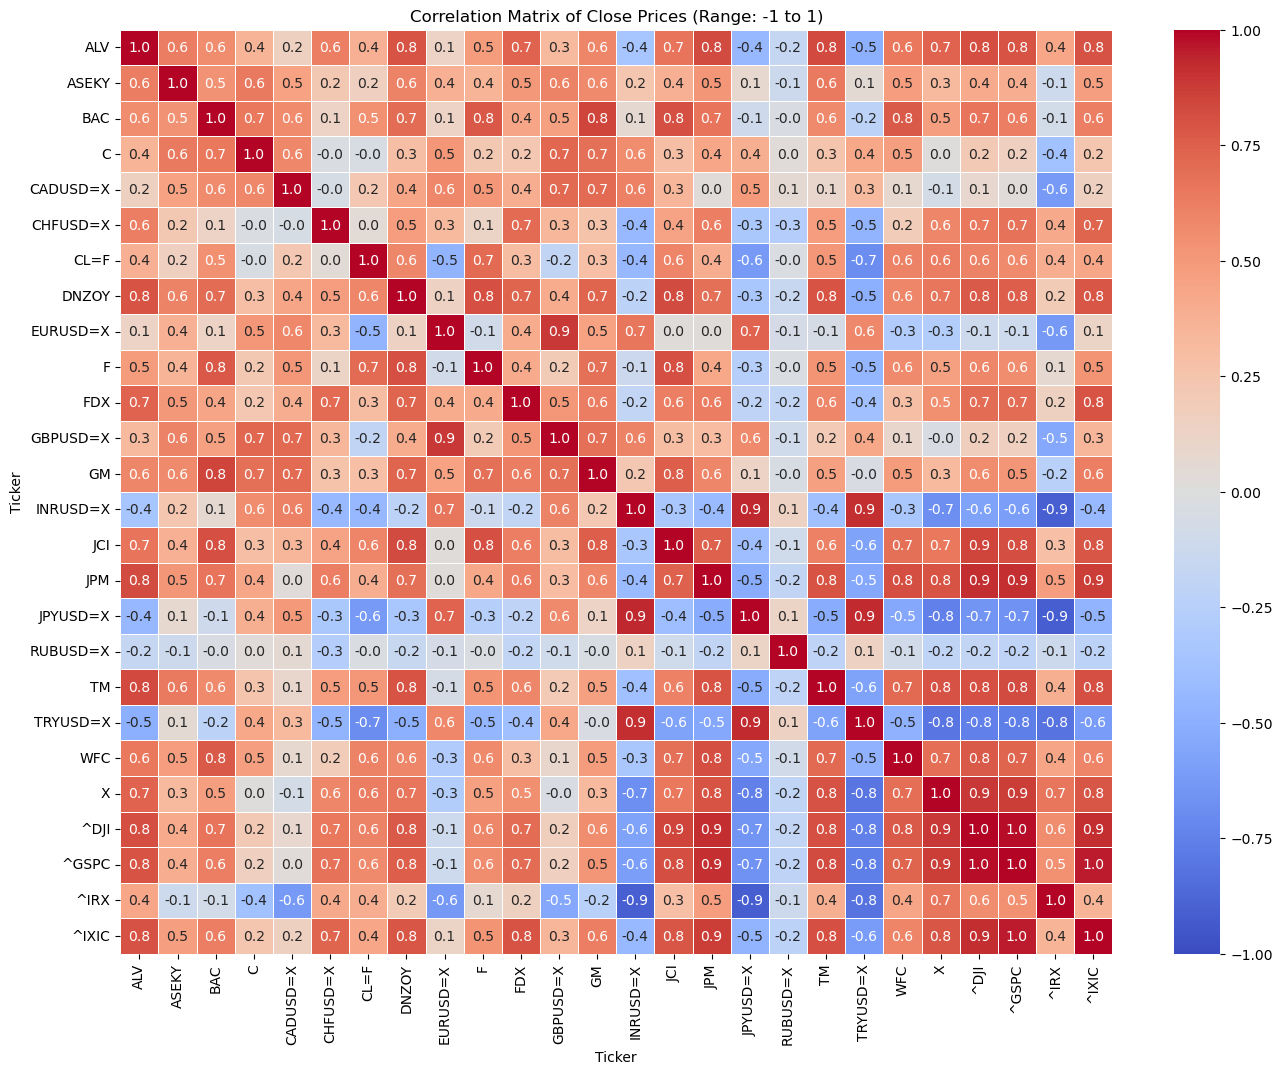

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the Close price data
close_prices = data['Close']

# Compute the correlation matrix of the Close prices
correlation_matrix = close_prices.corr()

# Enlarge the figure and format annotations to 1 decimal place
plt.figure(figsize=(16, 12))  # Enlarge the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, fmt='.1f')  # Format annotations
plt.title('Correlation Matrix of Close Prices (Range: -1 to 1)')
plt.show()


Now observe that Denso has strong correlation with the most of the other companies. So we can predict Denso stock market data with the help of other companies.

In [74]:
data = data.dropna()

In [75]:
data.to_csv('data.csv', index=True)

In [76]:
# Assuming 'correlation_matrix' has already been calculated as in the previous code

# Extract the correlations of Denso (ticker 'DNZOY') with other features
denso_correlations = correlation_matrix['DNZOY']

# Select features where the absolute correlation is greater than 0.4
selected_features = denso_correlations[abs(denso_correlations) > 0.4]

# Drop Denso itself from the list (as its correlation with itself is 1)
selected_features = selected_features.drop('DNZOY')

# Display the selected features and their correlations
print("Features with absolute correlation greater than 0.4 with Denso:")
print(selected_features)


Features with absolute correlation greater than 0.4 with Denso:
Ticker
ALV         0.795070
ASEKY       0.601779
BAC         0.700670
CADUSD=X    0.443990
CHFUSD=X    0.478364
CL=F        0.589301
F           0.809814
FDX         0.727085
GBPUSD=X    0.402475
GM          0.729331
JCI         0.827997
JPM         0.681532
TM          0.789873
TRYUSD=X   -0.505909
WFC         0.587271
X           0.658134
^DJI        0.769619
^GSPC       0.752659
^IXIC       0.781265
Name: DNZOY, dtype: float64


In [77]:
# Assuming your technical indicator functions (EMA, SMA, etc.) are already defined
# Calculate technical indicators for each feature
def calculate_indicators(df, ticker):
    df = gain_loss(df)
    df = SMA(df)
    df = EMA(df)
    df = RSI(df)
    df = SO(df)
    df = r_percent(df)
    df = MACD(df)
    df = ROC(df)
    df = PVT(df)
    df = Bollinger_Bands(df)
    
    # Rename columns to reflect the ticker (e.g., F_EMA, ALV_SMA)
    df = df.rename(columns=lambda col: f"{ticker}_{col}")
    
    return df

In [78]:
# Function to create the dataset using selected features and Denso's closing price
def create_dataset_1(data, selected_features, target_ticker='DNZOY'):
    df_features = pd.DataFrame()
    
    # Add the indicators and volume for each selected feature
    for ticker in selected_features.index:
        try:
            # Extract the individual ticker data (Close, High, Low, Volume)
            ticker_data = pd.DataFrame({
                'Close': data['Close'][ticker],
                'High': data['High'][ticker],
                'Low': data['Low'][ticker],
                'Volume': data['Volume'][ticker]
            })
        except KeyError:
            print(f"Ticker '{ticker}' not found in data. Skipping.")
            continue
        
        # Calculate indicators and add to the dataset
        indicator_data = calculate_indicators(ticker_data.copy(), ticker)
        
        # Merge the calculated indicators into the final feature dataset
        df_features = pd.concat([df_features, indicator_data], axis=1)
    
    # Add Denso's closing price as the predictor variable
    df_features[f'{target_ticker}_Close'] = data['Close'][target_ticker]
    
    # # Apply the prediction_class function on Denso's Close price
    # df_features = prediction_class(df_features)
    
    return df_features

In [79]:
# Create the first dataset (selected features with technical indicators and Denso's price)
dataset_reg = create_dataset_1(data, selected_features)

In [80]:
# # Step 2: Create the second dataset using all columns, all indicator variables, and Denso's closing price
# def create_dataset_2(data, target_ticker='DNZOY'):
#     df_all = pd.DataFrame()
    
#     # Iterate through all tickers in the data
#     for ticker in selected_features.index:
#         try:
#             # Extract the individual ticker data (Close, High, Low, Volume)
#             ticker_data = yf.download(ticker, period="5y")
#         except KeyError:
#             print(f"Ticker '{ticker}' not found in data. Skipping.")
#             continue
        
#         # Calculate indicators and add to the dataset
#         indicator_data = calculate_indicators(ticker_data.copy(), ticker)
#         full_data = pd.concat([ticker_data, indicator_data], axis=1)
        
#         # Merge the calculated indicators into the final dataset
#         df_all = pd.concat([df_all, full_data], axis=1)
    
#     # Add Denso's closing price as the predictor variable
#     df_all[f'{target_ticker}_Close'] = data['Close'][target_ticker]
    
#     # # Apply the prediction_class function on Denso's Close price
#     # df_all = prediction_class(df_all)
    
#     return df_all


In [81]:
# dataset_others = create_dataset_2(data)

In [82]:
df_all = pd.DataFrame()
for ticker in selected_features.index:
        try:
            # Extract the individual ticker data (Close, High, Low, Volume)
            ticker_data = yf.download(ticker, period="5y")
        except KeyError:
            print(f"Ticker '{ticker}' not found in data. Skipping.")
            continue
        
        # Calculate indicators and add to the dataset
        indicator_data = calculate_indicators(ticker_data.copy(), ticker)
        full_data = pd.concat([ticker_data, indicator_data], axis=1)
        
        # Merge the calculated indicators into the final dataset
        df_all = pd.concat([df_all, full_data], axis=1)
# Add Denso's closing price as the predictor variable
df_all["DNZOY_Close"] = yf.download("DNZOY", period="5y").Close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [83]:
data['Close']["DNZOY"]

Date
2019-10-25 00:00:00+00:00    11.390
2019-10-28 00:00:00+00:00    11.350
2019-10-29 00:00:00+00:00    11.480
2019-10-30 00:00:00+00:00    11.510
2019-10-31 00:00:00+00:00    11.585
                              ...  
2024-10-17 00:00:00+00:00    13.780
2024-10-18 00:00:00+00:00    13.940
2024-10-21 00:00:00+00:00    13.780
2024-10-22 00:00:00+00:00    13.680
2024-10-23 00:00:00+00:00    13.840
Name: DNZOY, Length: 1256, dtype: float64

In [84]:
dataset_others = df_all

In [85]:
dataset_reg = dataset_reg.rename(columns={'DNZOY_Close': 'DNZOY_Close_pred'})
dataset_others = dataset_others.rename(columns={'DNZOY_Close': 'DNZOY_Close_pred'})

In [86]:
dataset_reg = dataset_reg.dropna()

In [87]:
# Check the number of missing values in each column
missing_counts = dataset_others.isna().sum()
print(missing_counts[missing_counts > 0])  # Only display columns with missing values

Open                     49
High                     49
Low                      49
Close                    49
Adj Close                49
                         ..
^IXIC_ROC                61
^IXIC_PVT                50
^IXIC_Bollinger_Upper    68
^IXIC_Bollinger_Lower    68
DNZOY_Close_pred         49
Length: 552, dtype: int64


In [88]:
dataset_others = dataset_others.dropna()

In [89]:
# Save the dataset to a CSV file
dataset_reg.to_csv('dataset_reg.csv', index=True)
dataset_others.to_csv('dataset_others.csv', index=True)

## For classification

In [90]:
dataset_log_reg = dataset_reg.copy()
dataset_log_reg["DNZOY_Close_pred_class"]= np.where(dataset_log_reg['DNZOY_Close_pred'] < dataset_log_reg['DNZOY_Close_pred'].shift(-1), 1, 0)

# Drop the 'DNZOY_Close_pred' column
dataset_log_reg = dataset_log_reg.drop(columns=['DNZOY_Close_pred'])

# Drop any rows with missing values (NaN)
dataset_log_reg = dataset_log_reg.dropna()

In [91]:
dataset_others_class = dataset_others.copy()
dataset_others_class["DNZOY_Close_pred_class"]= np.where(dataset_others_class['DNZOY_Close_pred'] < dataset_others_class['DNZOY_Close_pred'].shift(-1), 1, 0)

# Drop the 'DNZOY_Close_pred' column
dataset_others_class = dataset_others_class.drop(columns=['DNZOY_Close_pred'])

# Drop any rows with missing values (NaN)
dataset_others_class = dataset_others_class.dropna()

In [92]:
# Save the dataset to a CSV file
dataset_log_reg.to_csv('dataset_log_reg.csv', index=True)
dataset_others_class.to_csv('dataset_others_class.csv', index=True)